## Infer point

Try to infer single endmember.

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

from model.inference import *
from model.hapke_model import get_USGS_r_mixed_hapke_estimate
from preprocessing.generate_USGS_data import generate_image
from utils.plotting import *
from utils.access_data import *
from utils.constants import *

def get_rmse(a, b): 
    return np.sqrt(np.mean((a - b)**2))

def print_error(m_actual, D_actual, m_est, D_est): 
    m_rmse = str(round(get_rmse(m_actual, m_est), 2))
    D_rmse = str(round(get_rmse(D_actual, D_est), 2))
    print(str(np.array(D_actual)) + ", "  + str(m_est) + ", " + str(m_rmse) + ", " + str(D_est) + ", " + str(D_rmse))
    return m_rmse, D_rmse

# plot_endmembers(CRISM_match=False)

In [ ]:
def test_inference(m_sample, D_sample, name):
    true_m = convert_arr_to_dict(m_sample)
    true_D = convert_arr_to_dict(D_sample)
    r_actual = get_USGS_r_mixed_hapke_estimate(m=true_m, D=true_D)
    est_m, est_D = infer_datapoint(d_seeds_index=[r_actual, 2, 0],
                                   iterations=NUM_ITERATIONS, 
                                   C=10, 
                                   V=GRAIN_SIZE_COVARIANCE)
    m_rmse, D_rmse=print_error(m_sample, D_sample, est_m, est_D)
    wavelengths = get_USGS_wavelengths()
    r_est = get_USGS_r_mixed_hapke_estimate(convert_arr_to_dict(est_m),  convert_arr_to_dict(est_D))
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
    ax.plot(wavelengths, r_est, label = "Estimated", color = "orange")
    ax.plot(wavelengths, r_actual, label = "Actual", color="blue")
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Reflectance")
    ax.legend()
    ax.set_title("RMSE M: " + str(m_rmse) + ", D: " + str(D_rmse))
    plt.ylim((0, 1)) 
    plt.savefig("../output/tests/" + str(name) + ".pdf") 

In [ ]:

# ["augite", "enstatite", "labradorite",  "olivine (Fo51)"]
m_sample = [0.6, 0.05,.05,0.4]
D_sample = [200, 300, 100, 200]
NAME = "mixed_7_1000_iters"
GRAIN_SIZE_COVARIANCE = 50
NUM_ITERATIONS = 1000
test_inference(m_sample, D_sample, NAME)

## Synthetic Image Generation
Create synthetic image resembling some realistic geology to have single, useful test image.

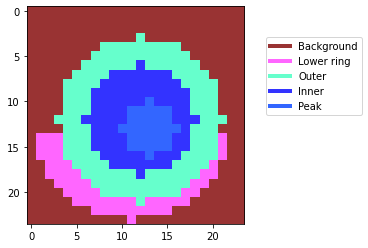

In [5]:
#Create 2D Numpy Matrix based on circles
from matplotlib.lines import Line2D
import matplotlib
def points_in_circle_np(radius, x0=0, y0=0):
    """
    Get X, Y coords for given circle
    """
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y

        

img_width = 24
img_height = 24
color_img = np.zeros((img_width,img_height,3))
test_img = np.zeros((img_width,img_height,1))

center_X = int(img_height/2)
center_Y = int(img_width/2)
outer_circle = points_in_circle_np(9, x0=center_X, y0=center_Y)
medium_circle =  points_in_circle_np(6, x0=center_X, y0=center_Y)
inner_circle =  points_in_circle_np(3, x0=center_X+1, y0=center_Y+1)
lower_ring = points_in_circle_np(11, x0=center_X, y0=center_Y-1)

circles = [lower_ring, 
           outer_circle, 
           medium_circle,
           inner_circle]
LR_C = [255, 102, 255]
O_C = [102, 255, 204]
M_C = [51, 51, 255]
I_C = [51, 102, 255]

RGB_MAP = {0: LR_C,
          1: O_C,
          2: M_C,
          3: I_C}
DEFAULT_COLOR =  [153, 51, 51]

for row_index, row in enumerate(color_img):
    for col_index, col in enumerate(row):
        color_img[row_index,col_index] = DEFAULT_COLOR
        test_img[row_index,col_index] = 0
            
for i, circle in enumerate(circles):
    for point in circle:
        x=point[0]
        y=point[1] 
        if i != 0:
            color_img[x,y] = RGB_MAP[i]
            test_img[x,y] = i + 1
        else:
            # only do lower, ring so threshold x 
            if x >= int(img_height*0.6):
                color_img[x,y] = RGB_MAP[i]
                test_img[x,y] = i + 1
# Plot image
figure, ax = plt.subplots(1)
color_img=np.array(color_img,np.int32)
            
plt.imshow(color_img)

a = Line2D([0], [0], color='#%02x%02x%02x' % tuple(DEFAULT_COLOR), lw=4) 
clines = [a] 
for c in list(RGB_MAP.values()):  
    hex_color='#%02x%02x%02x' % tuple(c)
    a = Line2D([0], [0], color=hex_color, lw=4) 
    clines.append(a)

ax.legend(clines, [ "Background", "Lower ring", "Outer", "Inner", "Peak"],loc=(1.1,0.5))

plt.savefig(PREPROCESSED_DATA + "SYNTHETIC/visual.pdf", bbox_inches='tight')

In [6]:
# ["augite", "enstatite", "labradorite",  "olivine (Fo51)"]
testing_regions = ["b", "l", "o", "i", "p"]
m_type_map = { 0:"b", 1:"l", 2 :"o", 3 :"i", 4:"p"}
region_ms = {"b": [0.3, 0.2,.1,0.4],
                "l": [0.7, 0, 0.3,0],
                "o": [0, 0.6,0.4,0],
                "i": [0.8, 0.2, 0, 0],
                "p": [0.3, 0, 0, 0.7]}
region_Ds = {"b": [200, 300, 100, 200],
                "l": [200, 300, 100, 200],
                "o": [200, 300, 100, 200],
                "i": [200, 300, 100, 200],
                "p": [200, 300, 100, 200]}
region_Rs = {}

# Mix each endmember; and then just add a bit of noise when creating image
for ttype in testing_regions: 
    m_map = {}
    D_map = {}
    for index, endmember in enumerate(USGS_PURE_ENDMEMBERS):
        m_map[endmember] = region_ms[ttype][index]
        D_map[endmember] = region_Ds[ttype][index]
    r = get_USGS_r_mixed_hapke_estimate(m_map, D_map)
    region_Rs[ttype] = r
    
with open(R_DIR + "../wavelengths.pickle", 'rb') as handle:
    wavelengths = pickle.load(handle)

    
r_image = np.zeros((img_width,img_height,len(wavelengths)))
m_image = np.zeros((img_width,img_height,len(USGS_PURE_ENDMEMBERS)))
D_image = np.zeros((img_width,img_height,len(USGS_PURE_ENDMEMBERS)))



In [28]:
################## Set DESIRED NOISE AMOUNT HERE ##################

NOISE_AMOUNT = 0.005

# NOISE_AMOUNT = "POISSON"
##################################################################

In [37]:

from skimage.util import random_noise
# Fill test image with synthetically mixed spectra 
i = 0
for row_index, row in enumerate(test_img):
    for col_index, col in enumerate(row):
        ttype_index = test_img[row_index, col_index]
        ttype = testing_regions[int(ttype_index)]
        cur_R = region_Rs[ttype]
        # Add Gaussian noise 
        noise = np.random.normal(loc=0, 
                                 scale=NOISE_AMOUNT, 
                                 size=len(wavelengths))
        noisy_r = noise + cur_R
        # add Poisson noise
#         noisy_r = random_noise(cur_R, mode="poisson")
        
        r_image[row_index, col_index] = noisy_r.copy()
#         eq=str(region_Rs[ttype])== str(r_image[row_index, col_index] ) 
        
        m_image[row_index, col_index] = region_ms[ttype]
        D_image[row_index, col_index] = region_Ds[ttype]
        i+=1
        
STR_NOISE = str("_noise_" + str(NOISE_AMOUNT))
with open(PREPROCESSED_DATA + "SYNTHETIC/r_img" + STR_NOISE + ".pickle", 'wb') as f:
    pickle.dump(r_image, f)
with open(PREPROCESSED_DATA + "SYNTHETIC/m_actual" + STR_NOISE + ".pickle", 'wb') as f: 
    pickle.dump(m_image, f)
with open(PREPROCESSED_DATA + "SYNTHETIC/D_actual" + STR_NOISE + ".pickle", 'wb') as f:
    pickle.dump(D_image, f)

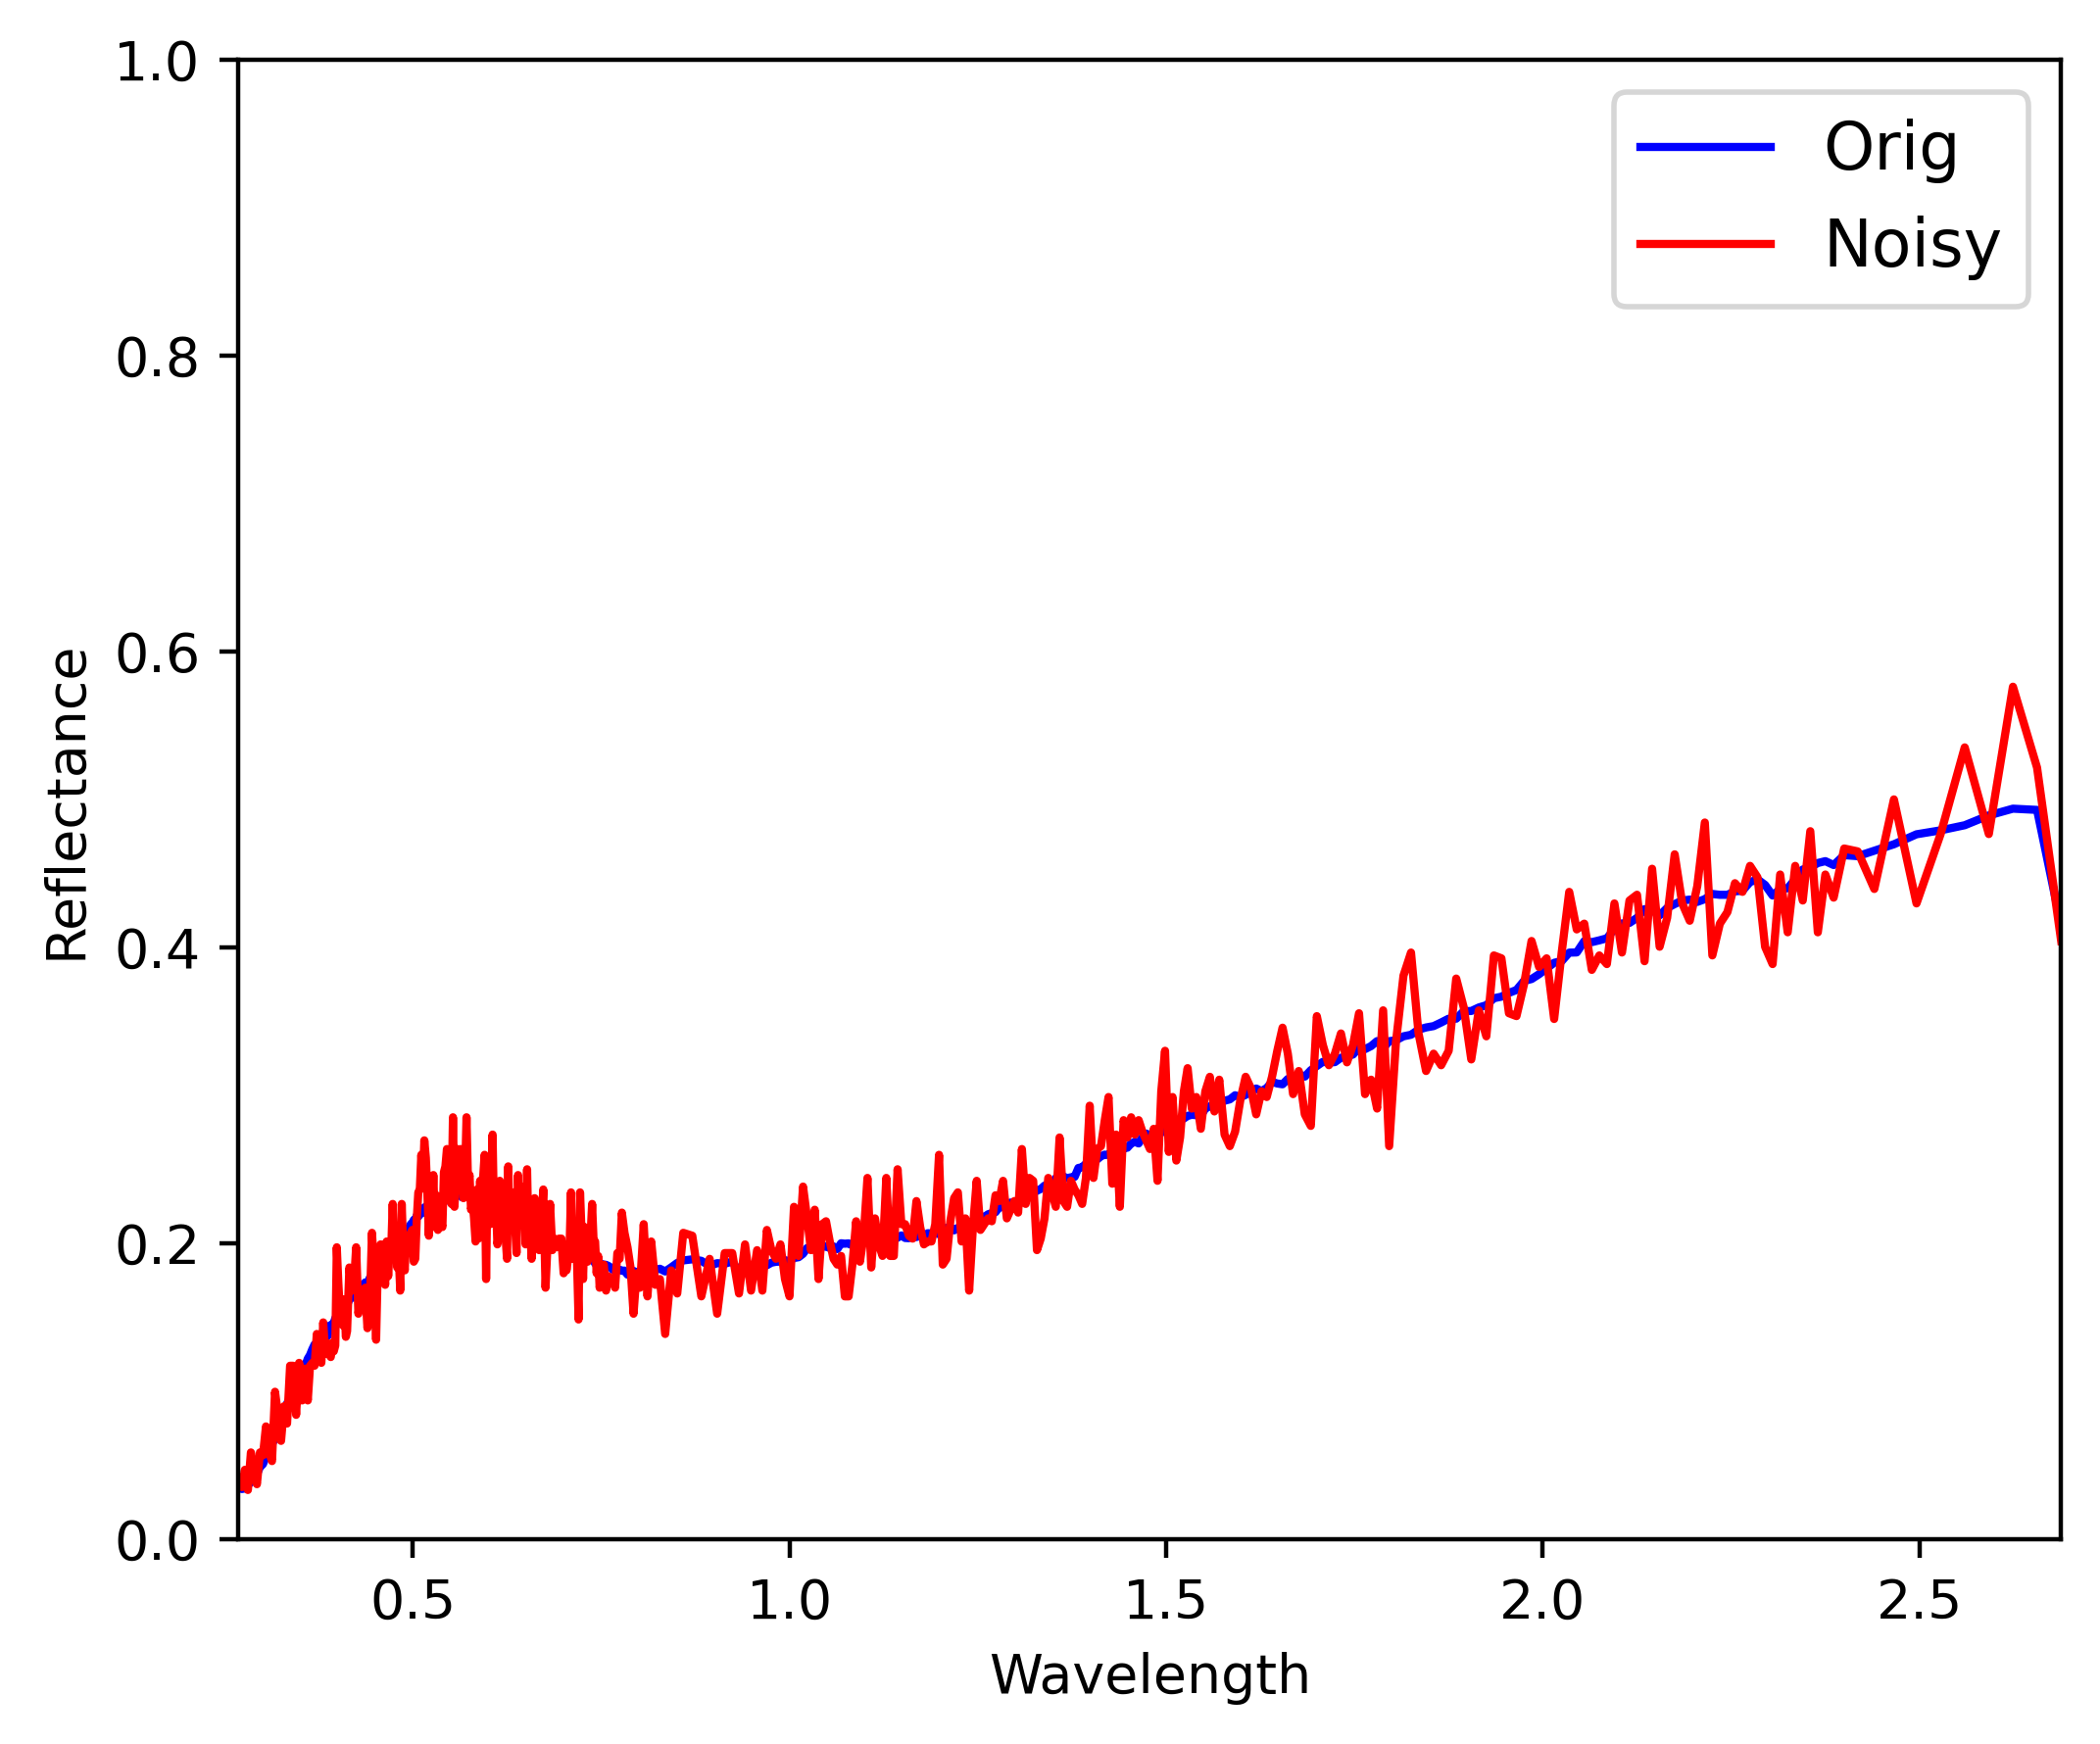

In [39]:
# Plot original vs noise added.
fig, ax = plt.subplots(figsize=(6, 5), dpi=400)
ax.plot(wavelengths, samp_spectra , color="blue", label="Orig")
ax.plot(wavelengths, pois_spectra, color="red", label="Noisy")
ax.set_ylabel("Reflectance")
ax.set_xlabel("Wavelength")
ax.set_ylim((0, 1))
ax.set_xlim((min(wavelengths), max(wavelengths)))
plt.legend(loc='best', fontsize=12)
plt.show()

In [22]:

# max_val = r_image.max()
# PEAK = 0.5 
# (r_image/(max_val * PEAK ) ) / PEAK

# p_r = np.random.poisson(lam=[0.02, 0.03])

# import numpy as np
# image = read_image("YOUR_IMAGE")  # need a rescale to be more realistic
# noisy = np.random.poisson(image / 255.0 * PEAK) / PEAK * 255  # noisy image

# import numpy as np
# image = read_image("YOUR_IMAGE") 
# noisemap = create_noisemap() 
# noisy = image + np.random.poisson(noisemap)  

array([[[0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        ...,
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85]],

       [[0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        ...,
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85]],

       [[0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        ...,
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85],
        [0.38, 0.39, 0.39, ..., 3.4 , 3.36, 2.85]],

       ...,

       [[0.38, 0.39, 0.3

Bit of spectra vis

In [ ]:
with open(PREPROCESSED_DATA + "SYNTHETIC/r_img_noise_0.pickle", 'rb') as F:
    R_image = pickle.load(F)
pix_10_10_orig = R_image[0,6]

with open(PREPROCESSED_DATA + "SYNTHETIC/r_img_noise_0.01.pickle", 'rb') as F:
    nr_image = pickle.load(F)
pix_10_10_noise = nr_image[0,6]


np.sqrt(np.mean((pix_10_10_orig-pix_10_10_noise )**2))

In [ ]:
# Plot original vs noise added.
fig, ax = plt.subplots(figsize=(6, 5), dpi=400)
ax.plot(wavelengths, pix_10_10_orig, color="blue", label="Orig")
ax.plot(wavelengths, pix_10_10_noise, color="red", label="Noisy")
ax.set_ylabel("Reflectance")
ax.set_xlabel("Wavelength")
ax.set_ylim((0, 1))
ax.set_xlim((min(wavelengths), max(wavelengths)))
plt.legend(loc='best', fontsize=12)
plt.show()

## Synthetic image testing

Run ind model on synthetic data

Load image

In [ ]:
################## Set testing NOISE AMOUNT HERE ##################

NOISE_AMOUNT = 0.005

##################################################################

In [ ]:
import numpy as np
import math
import os
import pickle

from model.models import *
from testing.run_inference import *
from preprocessing.generate_USGS_data import generate_image
from utils.plotting import *
from utils.constants import *

STR_NOISE = "_noise_" + str(NOISE_AMOUNT)
# STR_NOISE=""

with open(PREPROCESSED_DATA + "SYNTHETIC/m_actual" + STR_NOISE + ".pickle", 'rb') as F:
    m_actual = pickle.load(F)
with open(PREPROCESSED_DATA + "SYNTHETIC/D_actual" + STR_NOISE + ".pickle", 'rb') as F:
    D_actual = pickle.load(F)
with open(PREPROCESSED_DATA + "SYNTHETIC/r_img" + STR_NOISE + ".pickle", 'rb') as F:
    R_image = pickle.load(F)

# row_min = 1
# row_max = 6
# col_min = 1
# col_max = 6

# m_actual = m_actual[row_min:row_max,col_min:col_max,:]
# D_actual = D_actual[row_min:row_max,col_min:col_max,:]
# R_image = R_image[row_min:row_max,col_min:col_max,:]
print("Num pixels " + str(R_image.shape[0] * R_image.shape[1]))

In [ ]:
out_dir = "../output/actual/"
plot_actual(m_actual, output_dir=out_dir)
plot_actual(D_actual, output_dir=out_dir, mOrD="D")

Independent model 


In [ ]:
import time
start = time.time() 

m_est, D_est = ind_model(iterations=5,
                         image=R_image,
                         C=10,
                         V=50)
end = time.time()
mins = (end - start)/60
hours = mins/60
print("Took " + str(int(mins)) + " minutes, or " 
        + str(round(hours,2)) + " hours.")

EXP_NAME = "TEST_SYNTHETIC2"
if not os.path.exists('../output/' + EXP_NAME):
    os.makedirs('../output/' + EXP_NAME)
record_output(m_actual, D_actual, m_est, D_est, "ind/", EXP_NAME)

Segmentation Model

In [ ]:
m_est, D_est = seg_model(seg_iterations=80000, 
                            iterations=200, 
                            image=R_image,
                            C=10,
                            V=50,
                            MAX_SAD=0.029)
record_output(m_actual, D_actual, m_est, D_est, "seg/", "TEST_MAP")

MRF model

In [ ]:
m_est, D_est = mrf_model(iterations=200, 
                            image=R_image,
                            C=10,
                            V=50)
record_output(m_actual, D_actual, m_est, D_est, "mrf/", "TEST_MAP2")

Determining MAX_SAD for Segmentation Model (based on synthetic noise level)


In [ ]:

testing_regions = ["b", "l", "o", "i", "p"]
m_type_map = { 0:"b", 1:"l", 2 :"o", 3 :"i", 4:"p"}
region_ms = {"b": [0.3, 0.2,.1,0.4],
                "l": [0.7, 0, 0.3,0],
                "o": [0, 0.6,0.4,0],
                "i": [0.8, 0.2, 0, 0],
                "p": [0.3, 0, 0, 0.7]}
region_Ds = {"b": [200, 300, 100, 200],
                "l": [200, 300, 100, 200],
                "o": [200, 300, 100, 200],
                "i": [200, 300, 100, 200],
                "p": [200, 300, 100, 200]}

#  finding max sad
# If their SAD is <MAX_SAD we merge them. 
# Comes from manually examining pure data spectra vs. derived Hapke model spectra where dominant mineral is 80%. 
#
from model.segmentation import get_SAD

m_map = {}
D_map = {}
ttype='b'
for index, endmember in enumerate(USGS_PURE_ENDMEMBERS):
    m_map[endmember] = region_ms[ttype][index]
    D_map[endmember] = region_Ds[ttype][index]
r = get_USGS_r_mixed_hapke_estimate(m_map, D_map)
    
with open(R_DIR + "../wavelengths.pickle", 'rb') as handle:
    wavelengths = pickle.load(handle)

NOISE_AMOUNT=0
sads=[]
for t in range(50):
    noise = np.random.normal(loc=0, 
                             scale=NOISE_AMOUNT, 
                             size=len(wavelengths)) 

    noisy_r = r + noise
    for i, v in enumerate(noisy_r):
        if v <= 0:
            noisy_r[i]=0

    s=get_SAD(a=r, b=noisy_r)
    sads.append(s)
avg_SAD = np.mean(s)
print("Average SAD between pure and noisy R for ttype " + str(ttype) + 
      " with noise = " + str(NOISE_AMOUNT) + " is = " + str(round(avg_SAD,9)))
# print("we merge when target SAD < MAX_SAD, so wouldthis pass? " + str(avg_SAD<MAX_SAD))

fig, ax = plt.subplots(figsize=(6, 5), dpi=400)
ax.plot(wavelengths, r, color="blue", label="Orig")
ax.plot(wavelengths, noisy_r, color="red", label="Noisy")
ax.set_ylabel("Reflectance")
ax.set_xlabel("Wavelength")
ax.set_ylim((0, 1))
ax.set_xlim((min(wavelengths), max(wavelengths)))
plt.legend(loc='best', fontsize=12)
plt.show()



MRF Model